In [ ]:
# Importing necessary libraries for training and visualization
import numpy as np
import torch
import torchvision
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable

import matplotlib.pyplot as plt
import tqdm

In [ ]:
# Check to see that you are connected to a GPU
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [ ]:
# Defining a normalization function for our data using the transforms library.

# transforms.ToTensor() to scales values in the RGB channels typically (between 
# 0 and 255) to values between 0 and 1. We only have one channel in MNIST since
# it is a grayscale image.

# transforms.Normalize() normalizes the inputs to the given mean and std dev.
# Since we only have one channel, specify the mean and std dev as 1-D vectors.
mean = (0.5,)
std_dev = (0.5,)

normalization_transforms = [transforms.ToTensor(), 
                            transforms.Normalize(mean, std_dev)]

# Composing all of our desired transforms into a single object we'll use when
# loading out dataset.
transform = transforms.Compose(normalization_transforms)

In [ ]:
# Defining hyper-parameters and other values used by our model.

# Size of the batch our network sees. Batch size dictates how many examples the 
# model "sees" before computing updates (or backpropagation). 
batch_size = 100

# The percentage of our training dataset that will be used for validation 
# during training.
validation_split = .2

# Below are parameters for the shuffling of the dataset. We specify the random
# seed explicitly so your data-split is the same as this example.
shuffle_dataset = True
random_seed = 42

# Loading and create pytorch dataset objects for our training and test sets.

# MNIST is a traditional dataset that exists in the PyTorch library, however,
# if you are loading your own dataset there will be additional code here to 
# do so. We will see an example of how to do this in a future lecture.

train_set = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, \
                           train=True, transform=transform)
test_set = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, \
                          train=False, transform=transform)

# train_set = datasets.FashionMNIST('PATH_TO_STORE_TRAINSET', download=True, \
#                           train=True, transform=transform)
# test_set = datasets.FashionMNIST('PATH_TO_STORE_TESTSET', download=True, \
#                           train=False, transform=transform)

# Create validation split by taking a percentage of the training set:
dataset_size = len(train_set)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

# Shuffle the dataset to increase generalization and speed training
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

# Use the SubsetRandomSampler to randomly sample the training dataset for 
# training and validation data. We will feed this into the dataloader below.
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Create dataloader objects - will be used during training and inference
# to iterate over the data.
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, \
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, \
                                         sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, \
                                          shuffle=False)

In [ ]:
# Verify we've loaded the number of training and testing samples we expect.
print(len(train_set), len(test_set))

# Let's visualize data from our validation to make sure it's loaded correctly.
# Each time this is run, a random sample will be viewed.
dataiter = iter(val_loader)
images, labels = dataiter.next()

# Making sure the dimensions of the image and label tensors are as expected
# is critical, since otherwise you'll be faced with a slew of dimension errors.

# We should see the image shape listed as [batch_size, channels, height, width]
# and label shape as [batch_size,]
print("Image shape: ", images.shape, "Label shape: ", labels.shape)
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

In [ ]:
# Here we are going to create our neural network class by inheiriting the 
# nn.Module class. The main functions to notice are the initialization function 
# __init__() and forward propagation function forward().

class Net(nn.Module):

  # We initialize our neural net by defining the input size, number of nodes
  # in hidden layers, and the total number of classes we are detecting.
  def __init__(self, num_classes):

    # IMPORTANT: This is often forgotten, but make sure to make a super call.
    super(Net, self).__init__()

    pass
  
  # Below we construct the output of the forward propagation pass of the neural
  # net using the layers and activation functions defined in the Net constructor.
  def forward(self, x):
    pass

In [ ]:
# Create a neural network object with the specified number of input neurons,
# hidden neurons, and output neurons (or total classes)

net = Net(784, 16, 10)

# We use cross-entropy loss with the Adam optimizer. No need to understand what
# these two mean just yet, we will go over cross-entropy soon and the Adam 
# optimizer in a later lecture.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [ ]:
# Function for getting accuracy, adapted from: 
# https://towardsdatascience.com/a-simple-starter-guide-to-build-a-neural-network-3c2cf07b8d7c

def get_accuracy(loader, my_net):
  correct = 0
  total = 0
  for images, labels in loader:
      images = Variable(images)
      outputs = my_net(images)
      _, predicted = torch.max(outputs.data, 1)  
      total += labels.size(0)               
      correct += (predicted == labels).sum()

  return 100 * correct / total

In [ ]:
# Here we create our training loop, which runs for the number of epochs
# specified below. 

# 1 Epoch represents one entire pass through your training dataset, so 20 epochs
# means that your model will see each data point ~20 times during training.
num_epochs = 5

loss_tracker = []

for epoch in range(num_epochs):
  # Initialize random value for loss just for displaying purposes
  loss = torch.tensor([100])

  # Using the tqdm for nice training visuals
  progress_bar = tqdm.notebook.tqdm(train_loader, ncols=1000)

  # We load a batch of images and their corresponding labels here and continue
  # until we trained on all batches.
  for i, (images, labels) in enumerate(progress_bar):
    # Convert torch tensor to a vector of size 784 in order to send it to input
    # layer
    images = Variable(images)
    labels = Variable(labels)

    if i == 0:
      print(images.size(0))

    # Clear the gradients before performing backpropagation
    optimizer.zero_grad()
    # Perform the forward pass - this call of net calls the forward() fn
    outputs = net(images)
    # Compute loss on the output of the forward pass and desired label
    loss = criterion(outputs, labels)
    # Compute the gradients with respect to the loss function
    loss.backward()      
    # Update the weights in the neural network using the optimizer/backprop
    optimizer.step()

    # Track losses for plotting later
    loss_tracker.append(loss.data)                                  

    # Visualization code
    if (i+1) % 100 == 0 or (i+1) == len(train_loader):   
      progress_bar.set_description('Epoch [%d/%d], Step [%d/%d], Val Acc: %d, Training Loss: %.4f'
              %(epoch+1, num_epochs, i+1, len(train_loader), \
                get_accuracy(val_loader, net), loss.data))


In [ ]:
# Print the training and test accuracy
train_acc = get_accuracy(train_loader, net)
test_acc = get_accuracy(test_loader, net)

print('Accuracy of the network on the 60K train images: %d %%' % (train_acc))
print('Accuracy of the network on the 10K test images: %d %%' % (test_acc))

In [ ]:
# Plot the loss over time
plt.plot(loss_tracker)
plt.ylabel("Loss")
plt.xlabel("Step Number")
plt.title("Loss over time")
plt.show()

In [ ]:
# Let's visualize where the model is making bad predictions and get an idea of 
# why that's happening
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1)

correct = 0
misclassified_images = []
misclassified_labels = []
misclassified_preds = []
for images, labels in test_loader:
    images = Variable(images)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)  
    correct += (predicted == labels).sum()

    if predicted != labels:
      misclassified_images.append(images.view(1, 28, 28))
      misclassified_labels.append(labels)
      misclassified_preds.append(predicted)

Actual Label:  tensor([7])
Prediction:  tensor([9])


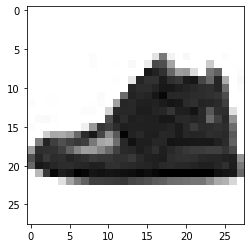

In [ ]:
# Keep running this cell to see randomly chosen images that the model misclassified
# in the testing set.
rand_idx = np.random.randint(len(misclassified_images))
plt.imshow(misclassified_images[rand_idx].numpy().squeeze(), cmap='gray_r');
print("Actual Label: ", misclassified_labels[rand_idx])
print("Prediction: ", misclassified_preds[rand_idx])